In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# pd.set_option('display.max_rows', 100)
# pd.set_option('display.max_columns', 200)

In [2]:
app_train = pd.read_csv('application_train.csv') 
app_test = pd.read_csv('application_test.csv')

In [4]:
def get_apps_dataset():
    app_train = pd.read_csv('application_train.csv') 
    app_test = pd.read_csv('application_test.csv')
    apps = pd.concat([app_train, app_test])
    return apps

apps = get_apps_dataset()

In [5]:
def get_apps_processed(apps):
    
    # EXT_SOURCE_X FEATURE 가공
    apps['APPS_EXT_SOURCE_MEAN'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    apps['APPS_EXT_SOURCE_STD'] = apps[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    apps['APPS_EXT_SOURCE_STD'] = apps['APPS_EXT_SOURCE_STD'].fillna(apps['APPS_EXT_SOURCE_STD'].mean())
    
    # AMT_CREDIT 비율로 Feature 가공
    apps['APPS_ANNUITY_CREDIT_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_CREDIT']
    apps['APPS_GOODS_CREDIT_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_CREDIT']
    
    # AMT_INCOME_TOTAL 비율로 Feature 가공
    apps['APPS_ANNUITY_INCOME_RATIO'] = apps['AMT_ANNUITY']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CREDIT_INCOME_RATIO'] = apps['AMT_CREDIT']/apps['AMT_INCOME_TOTAL']
    apps['APPS_GOODS_INCOME_RATIO'] = apps['AMT_GOODS_PRICE']/apps['AMT_INCOME_TOTAL']
    apps['APPS_CNT_FAM_INCOME_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['CNT_FAM_MEMBERS']
    
    # DAYS_BIRTH, DAYS_EMPLOYED 비율로 Feature 가공
    apps['APPS_EMPLOYED_BIRTH_RATIO'] = apps['DAYS_EMPLOYED']/apps['DAYS_BIRTH']
    apps['APPS_INCOME_EMPLOYED_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_EMPLOYED']
    apps['APPS_INCOME_BIRTH_RATIO'] = apps['AMT_INCOME_TOTAL']/apps['DAYS_BIRTH']
    apps['APPS_CAR_BIRTH_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_BIRTH']
    apps['APPS_CAR_EMPLOYED_RATIO'] = apps['OWN_CAR_AGE'] / apps['DAYS_EMPLOYED']
    
    return apps

#### Previous 데이터 로딩

In [6]:
prev = pd.read_csv('previous_application.csv')
print(prev.shape, apps.shape)

(1670214, 37) (356255, 122)


#### application과 previous outer 조인하고 누락된 집합들 확인

In [8]:
# indicator는 양쪽의 집합이 있는지 아니면 한쪽만 있는지 알려줌
# _merge라는 칼럼이 생기고, left만 생기면 left_only, right에만 있으면 right_only임
prev_app_outer = prev.merge(apps['SK_ID_CURR'], on='SK_ID_CURR', how='outer', indicator=True)
prev_app_outer['_merge'].value_counts()

both          1670214
right_only      17398
left_only           0
Name: _merge, dtype: int64

In [9]:
prev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

### 주요 컬럼 EDA 수행
#### SK_ID_CURR당 평균 SK_ID_PREV 건수 구하기
- groupby로 평균 건수 구함
- boxplot으로 시각화

In [18]:
# SK_ID_CURR로 groupby하여 평균 건수 구함
prev.groupby('SK_ID_CURR')['SK_ID_CURR'].count().mean()

4.928964135313716

In [20]:
# box plot으로 시각화. 일부 데이터는 특정 SK_ID_CURR로 몇십개의 데이터가 있음
sns.boxplot(prev.groupby('SK_ID_CURR')['SK_ID_CURR'].count())

KeyError: 0

#### 숫자형 피처들의 Histogram을 TARGET 유형에 따라 비교
- application_train의 TARGET 값을 가져오기 위해 prev app_train을 inner join 후 TARGET 유형에 따라 비교
- 숫자형 컬럼 명 필터링

In [21]:
app_prev = prev.merge(app_train[['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR', how='left')
app_prev.shape

(1670214, 38)

In [22]:
def show_hist_by_target(df, columns):
    cond_1 = (df['TARGET'] == 1)
    cond_0 = (df['TARGET'] == -0)
    
    for col in columns:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4), squeeze=False)
        sns.violinplot(x='TARGET', y=col, data=df, ax=axs[0][0])
        sns.distplot(df[cond_0][col], ax=axs[0][1], label='0', color='blue')
        sns.distplot(df[cond_1][col], ax=axs[0][1], label='1', color='red')

In [24]:
num_columns = app_prev.dtypes[app_prev.dtypes != 'object'].index.tolist()
num_columns = [column for column in num_columns if column not in ['SK_ID_PREV', 'SK_ID_CURR', 'TARGET']]
print(num_columns)

['AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE', 'HOUR_APPR_PROCESS_START', 'NFLAG_LAST_APPL_IN_DAY', 'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'DAYS_DECISION', 'SELLERPLACE_AREA', 'CNT_PAYMENT', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL']


C:\Users\miming\AppData\Local\Temp\ipykernel_6652\3057590423.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[cond_0][col], ax=axs[0][1], label='0', color='blue')
C:\Users\miming\AppData\Local\Temp\ipykernel_6652\3057590423.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[cond_1][col

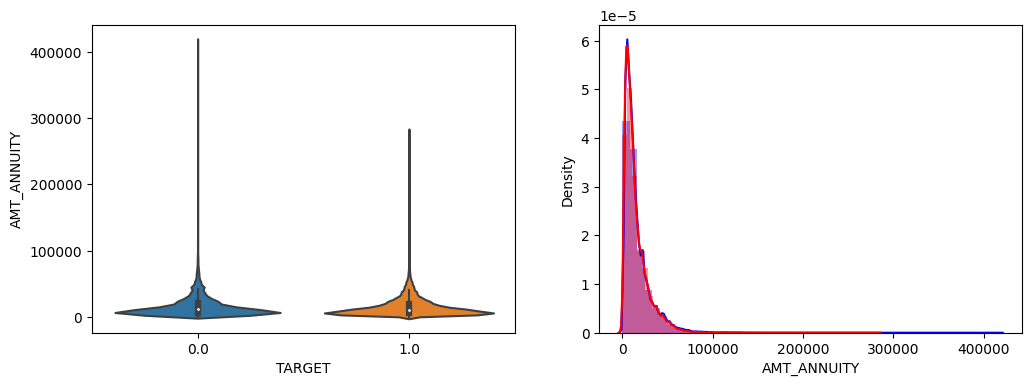

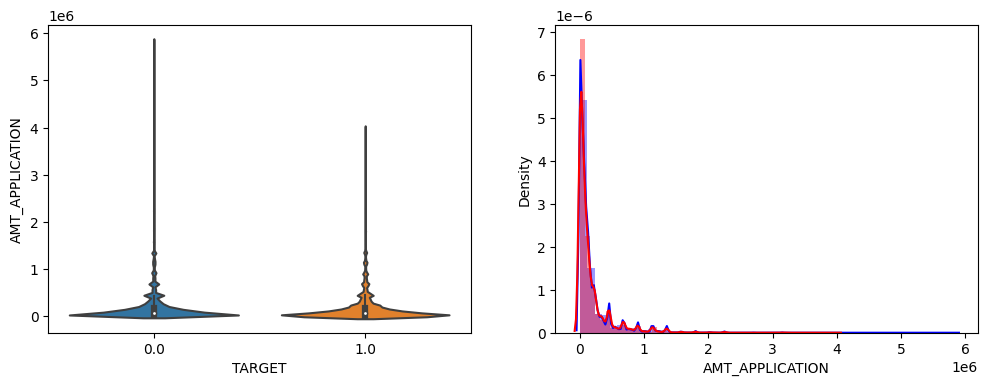

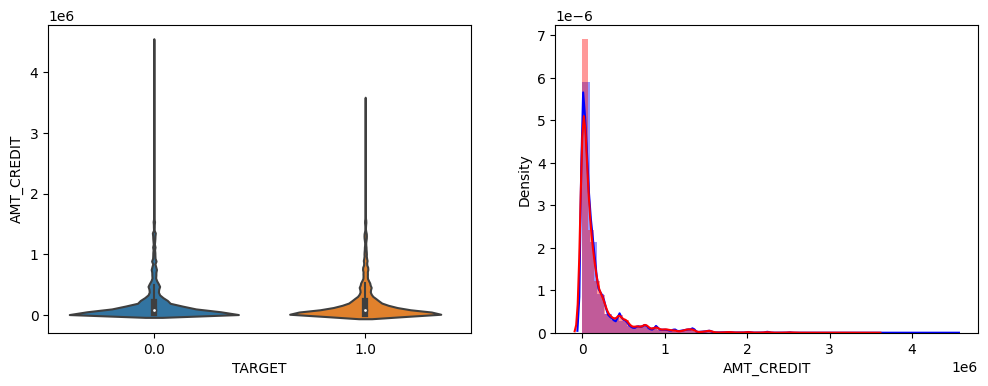

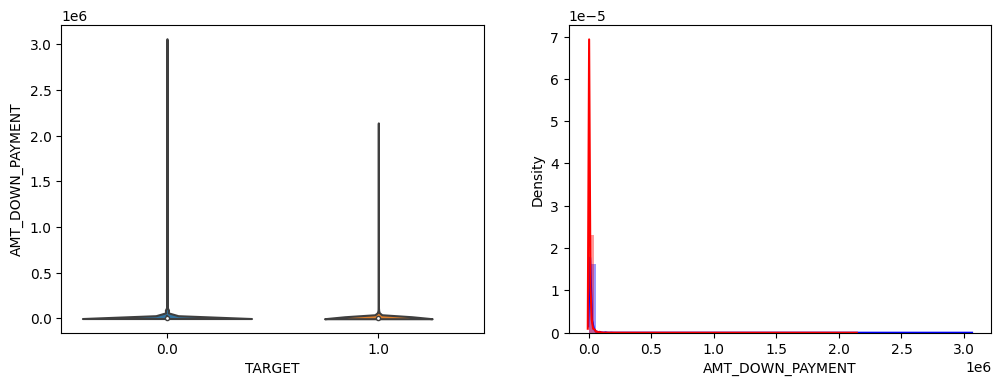

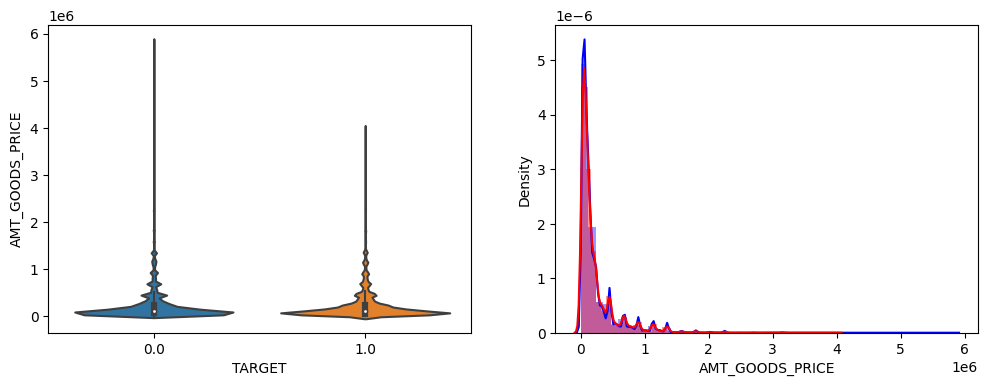

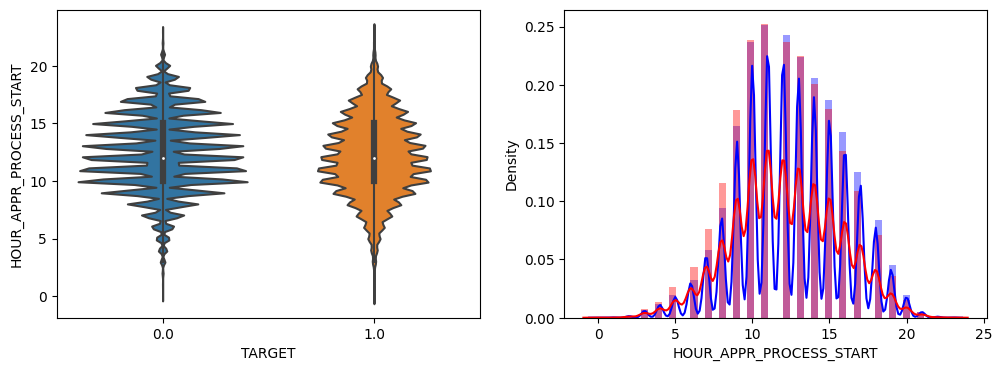

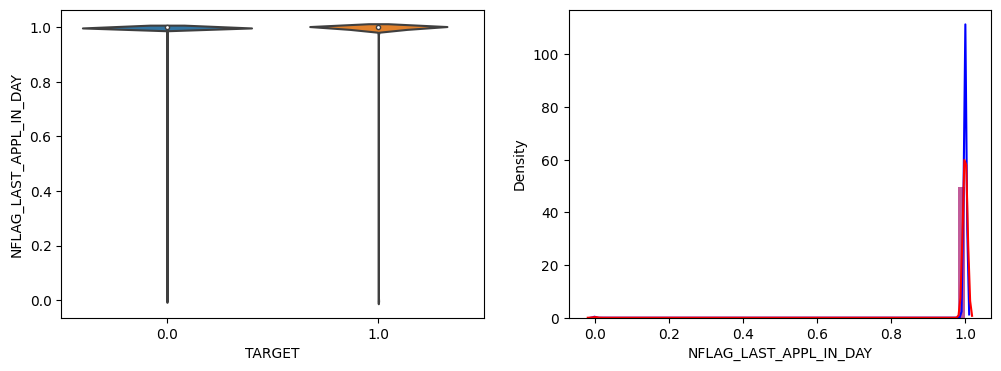

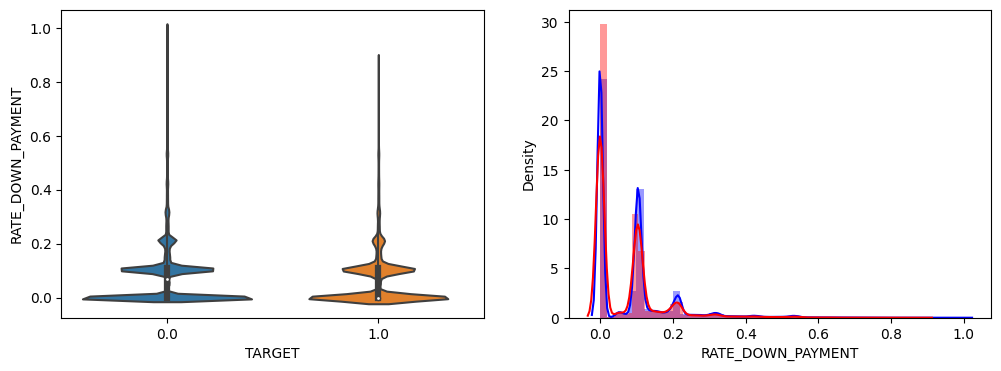

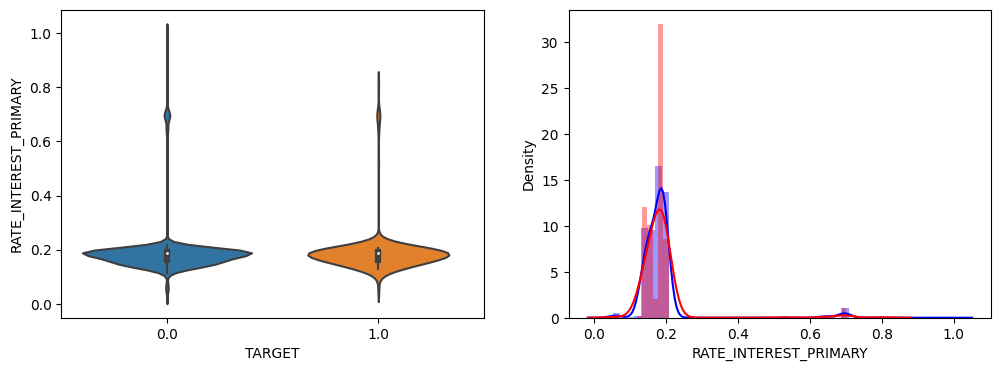

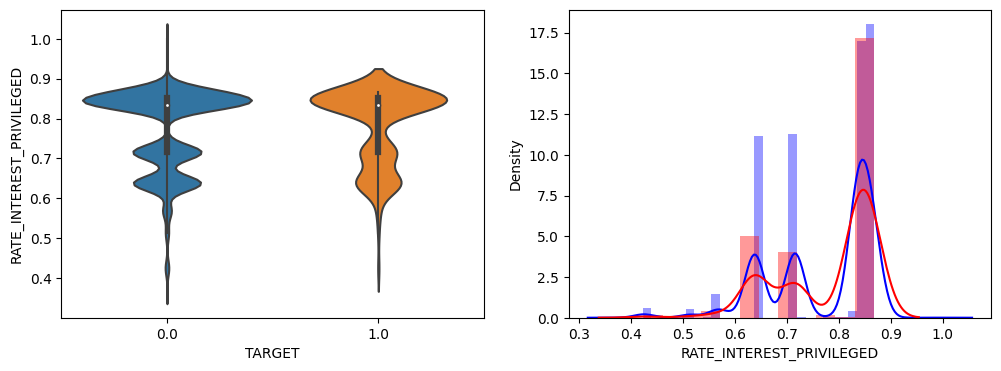

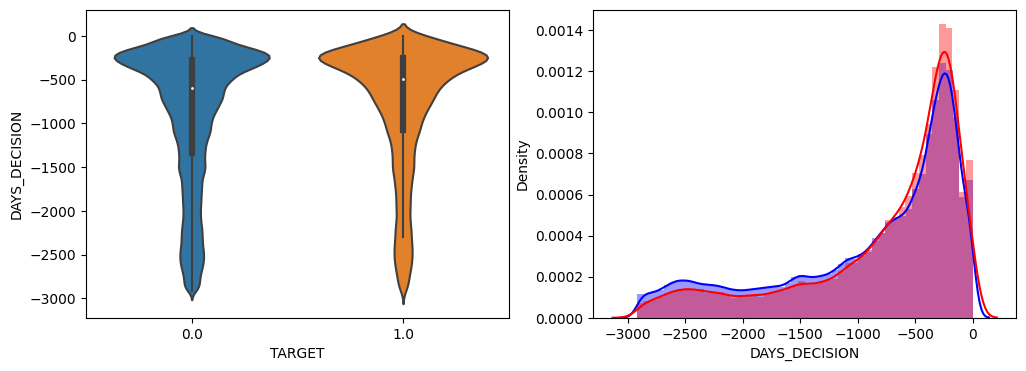

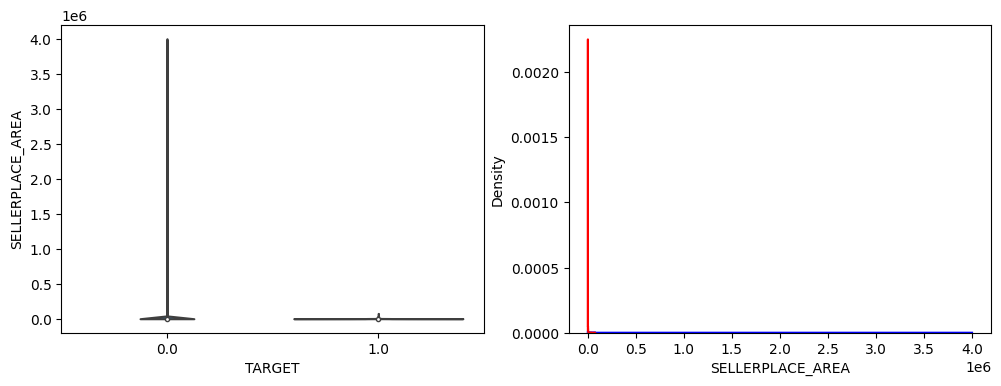

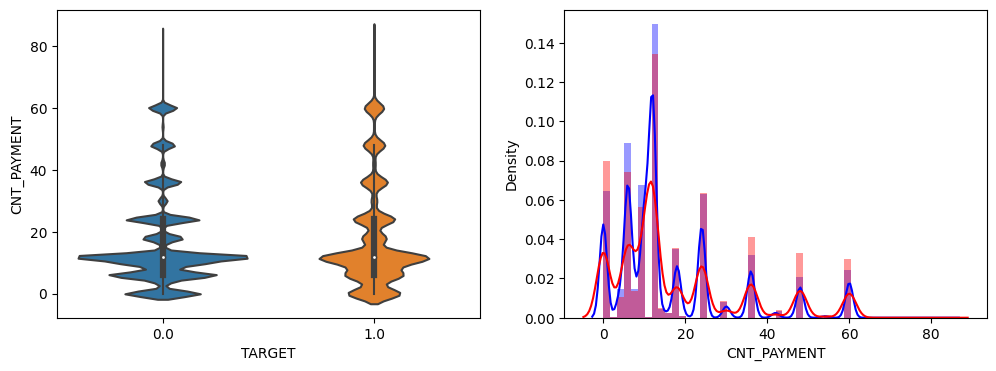

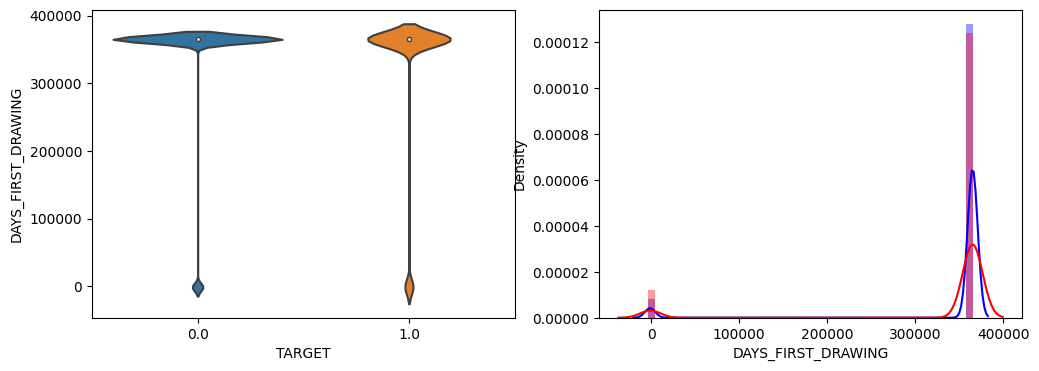

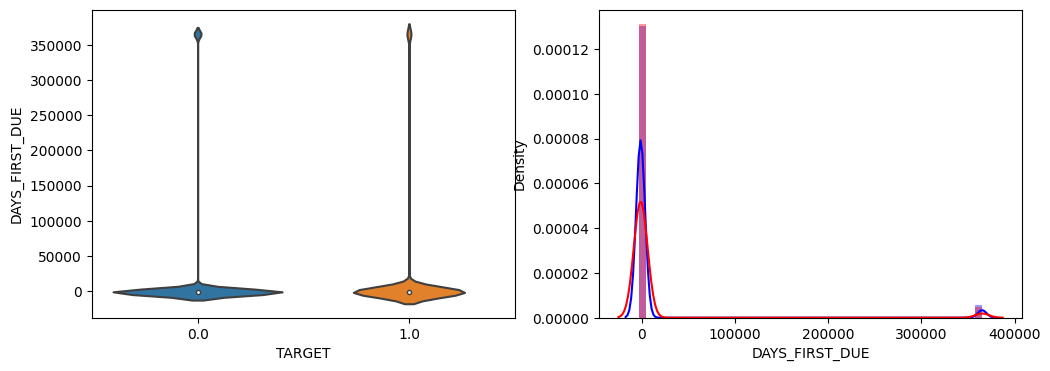

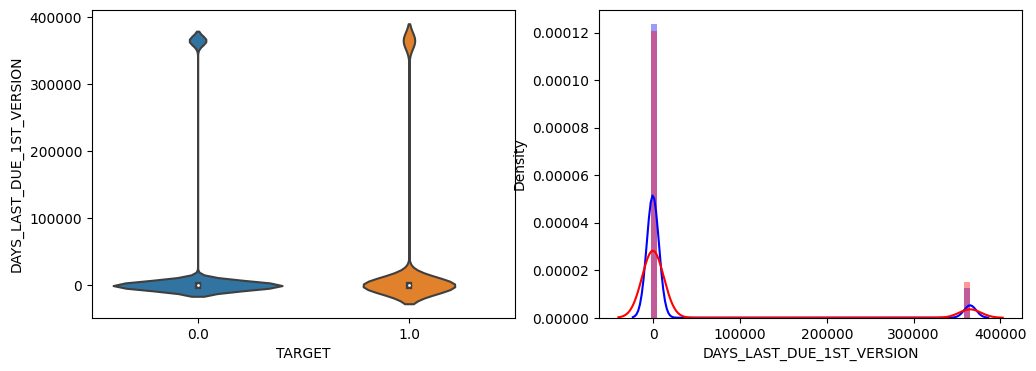

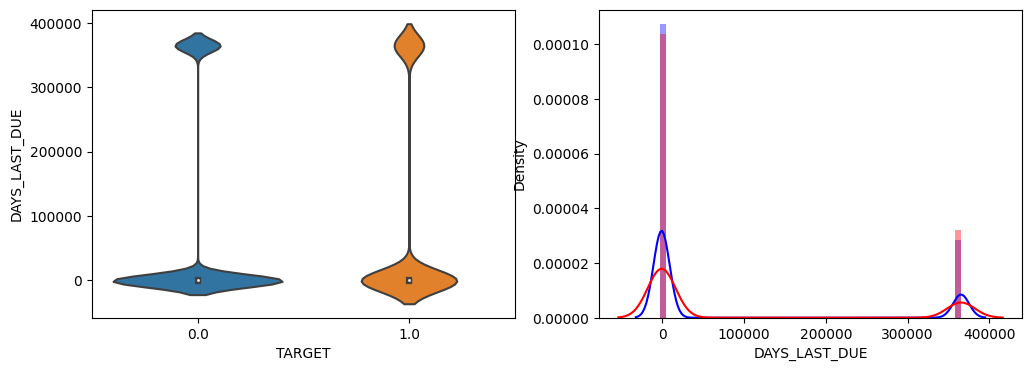

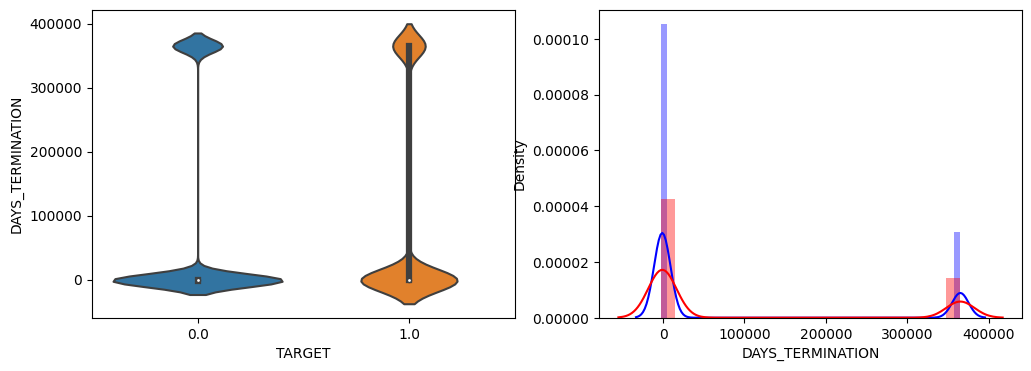

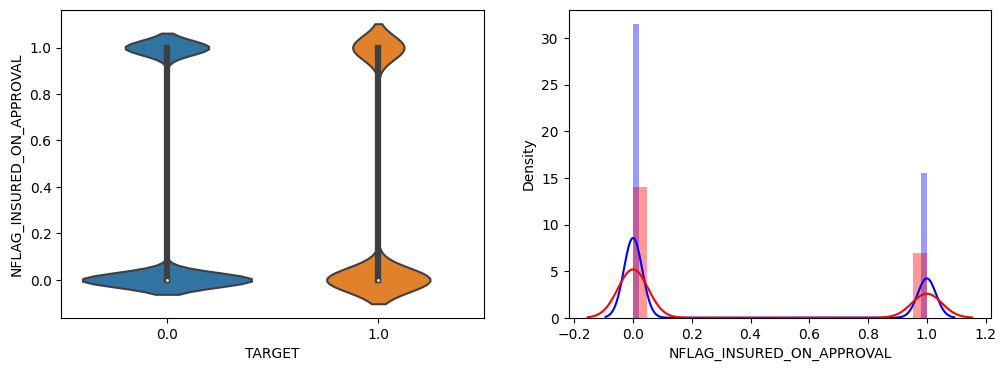

In [25]:
show_hist_by_target(app_prev, num_columns)

* AMT_ANNUITY, AMT_CREDIT, AMT_APPLICATION, AMT_GOODS_CREDIT는 TARGET=1일 경우에 소액 비율이 약간 높음(큰 차이는 아님)
* RATE_DOWN_PAYMENT는 큰 차이 없음. 
* RATE_INTEREST_PRIMARY, RATE_INTEREST_PRIVILEGED 는 NULL값이 매우 많아서 판단 어려움
* DAYS_DECISION은 TARGET=1일 때 0에 가까운(최근일)값이 약간 더 많음. 
* DAYS_FIRST_DRAWING, DAYS_FIRST_DUE, DAYS_LAST_DUE_1ST_VERSION, DAYS_LAST_DUE, DAYS_TERMINATION은 365243 값이 매우 많음. 

### Category feature 들의 histogram을 TARGET 유형에 따라 비교

In [26]:
object_columns = app_prev.dtypes[app_prev.dtypes == 'object'].index.tolist()
object_columns

['NAME_CONTRACT_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'NAME_CASH_LOAN_PURPOSE',
 'NAME_CONTRACT_STATUS',
 'NAME_PAYMENT_TYPE',
 'CODE_REJECT_REASON',
 'NAME_TYPE_SUITE',
 'NAME_CLIENT_TYPE',
 'NAME_GOODS_CATEGORY',
 'NAME_PORTFOLIO',
 'NAME_PRODUCT_TYPE',
 'CHANNEL_TYPE',
 'NAME_SELLER_INDUSTRY',
 'NAME_YIELD_GROUP',
 'PRODUCT_COMBINATION']

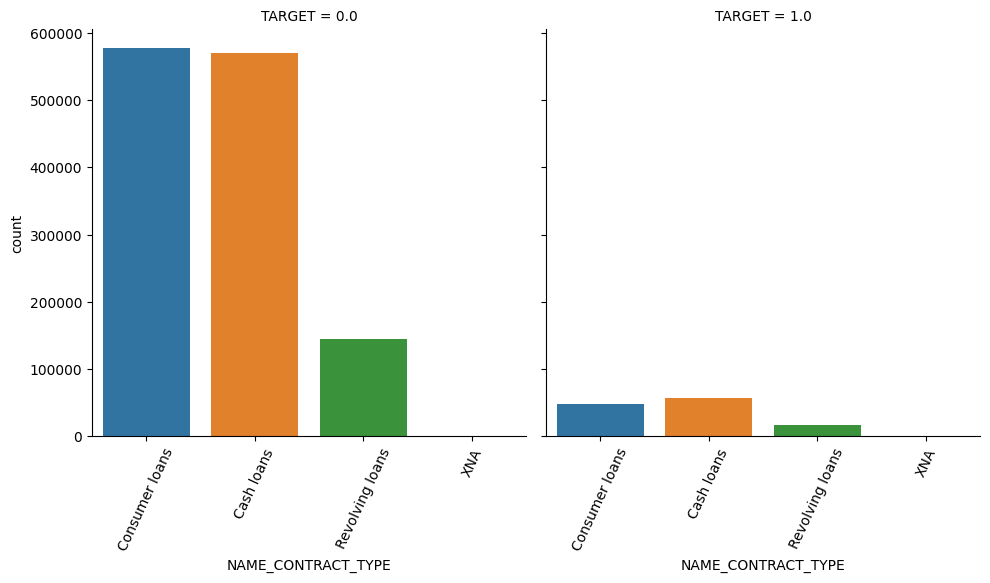

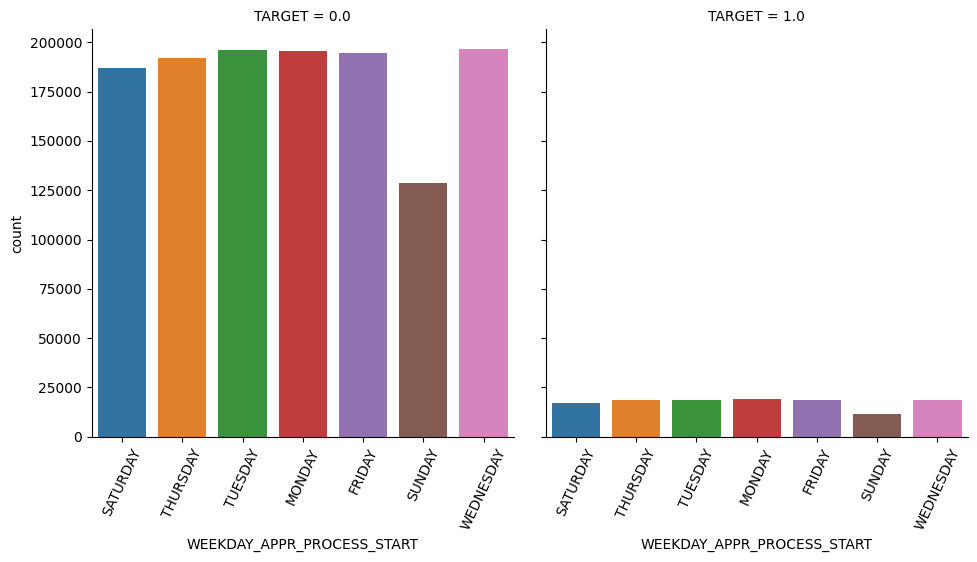

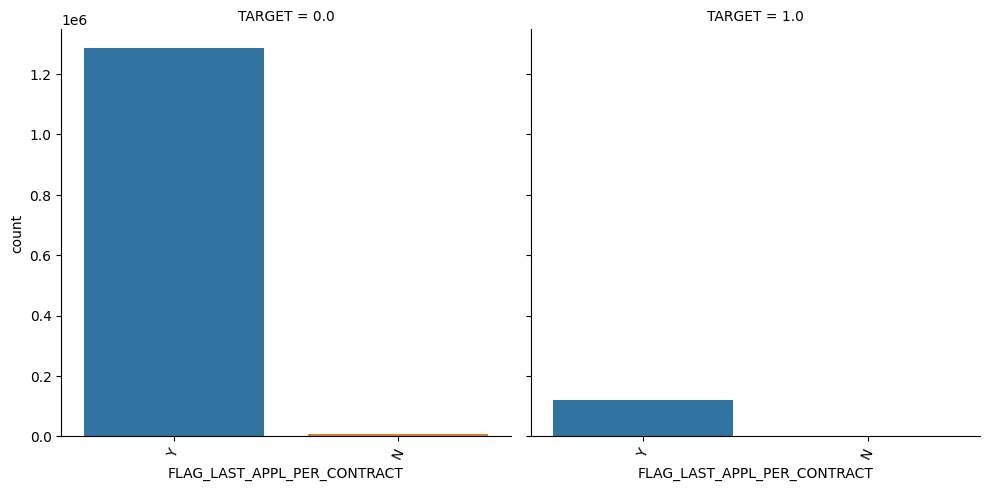

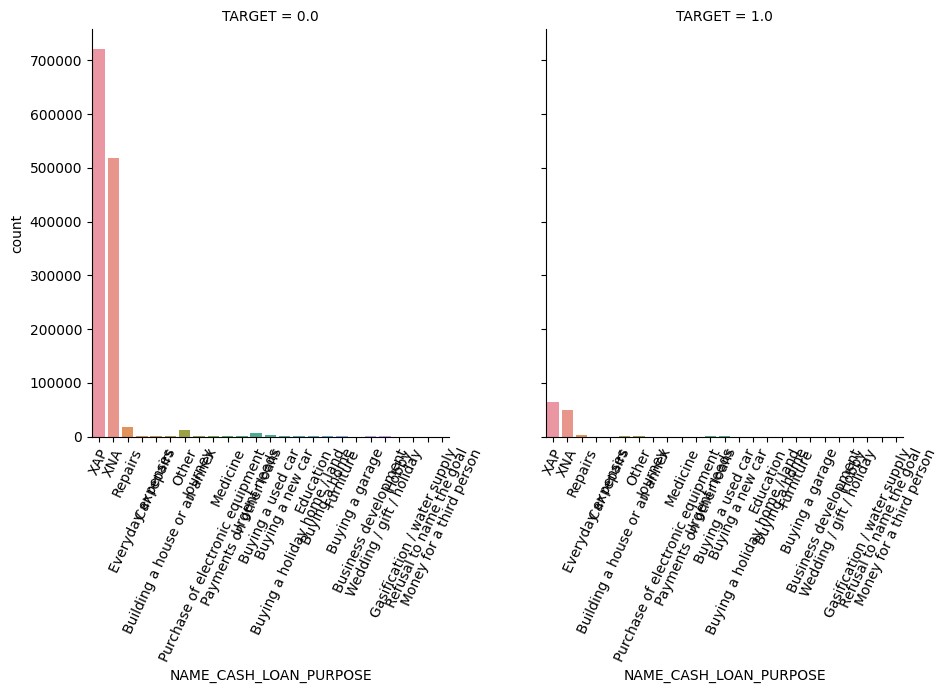

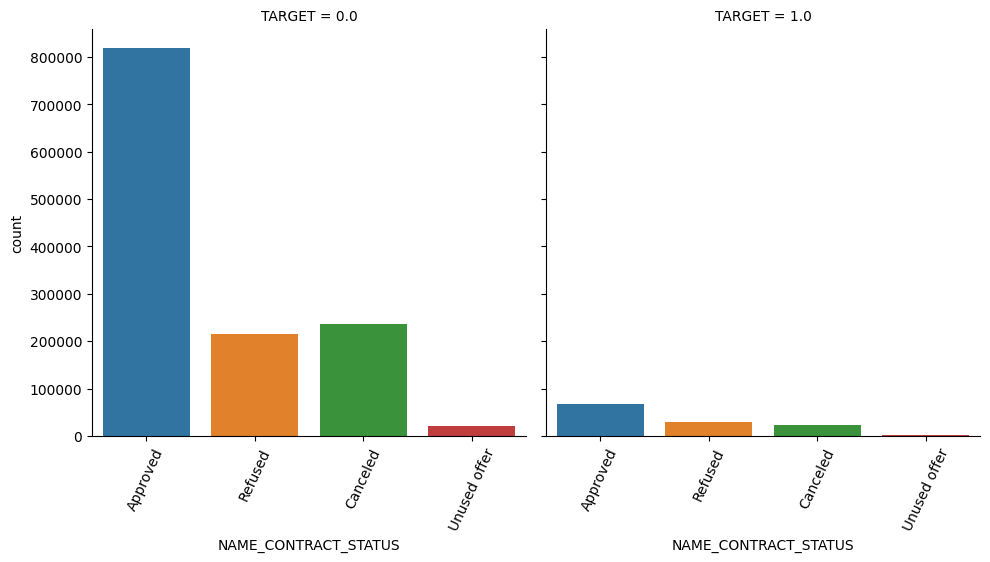

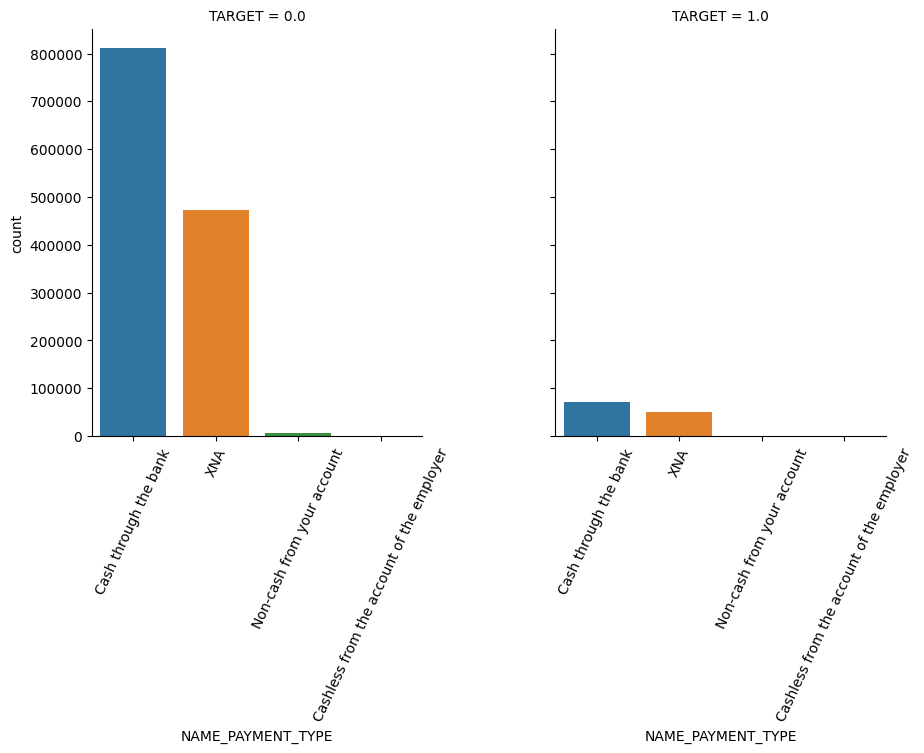

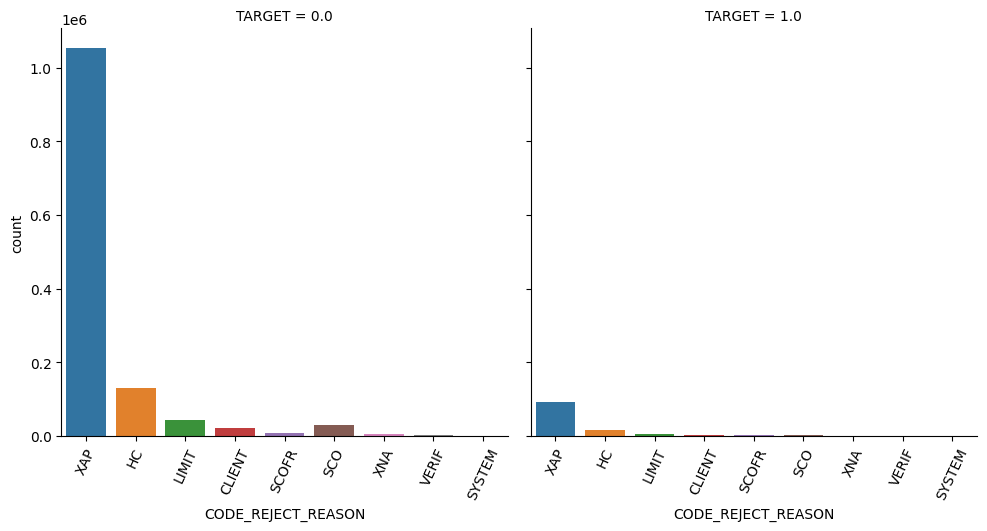

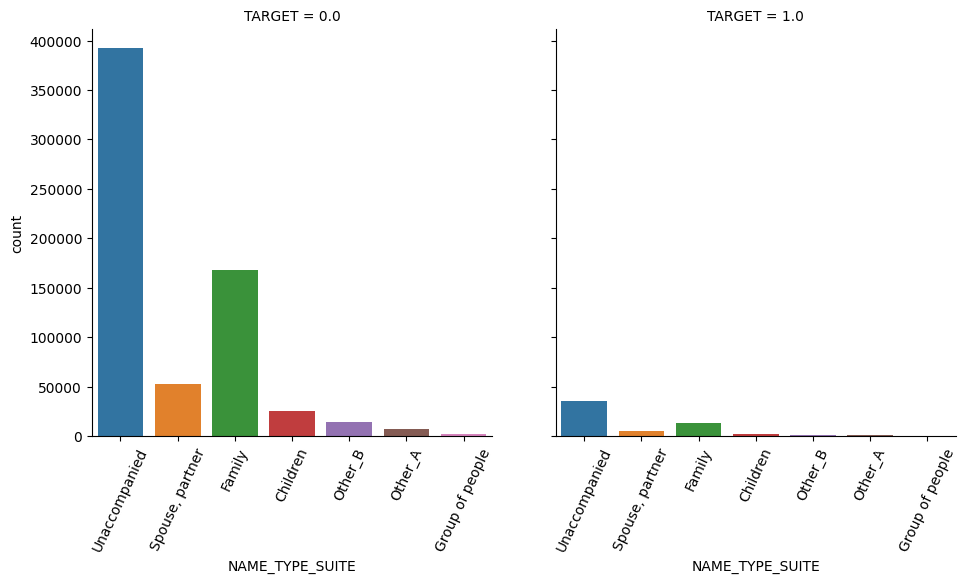

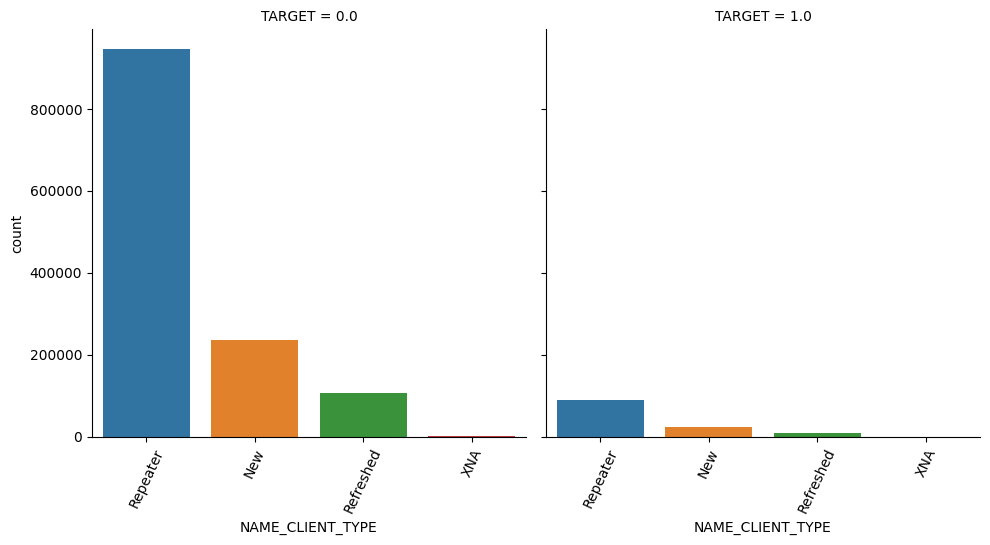

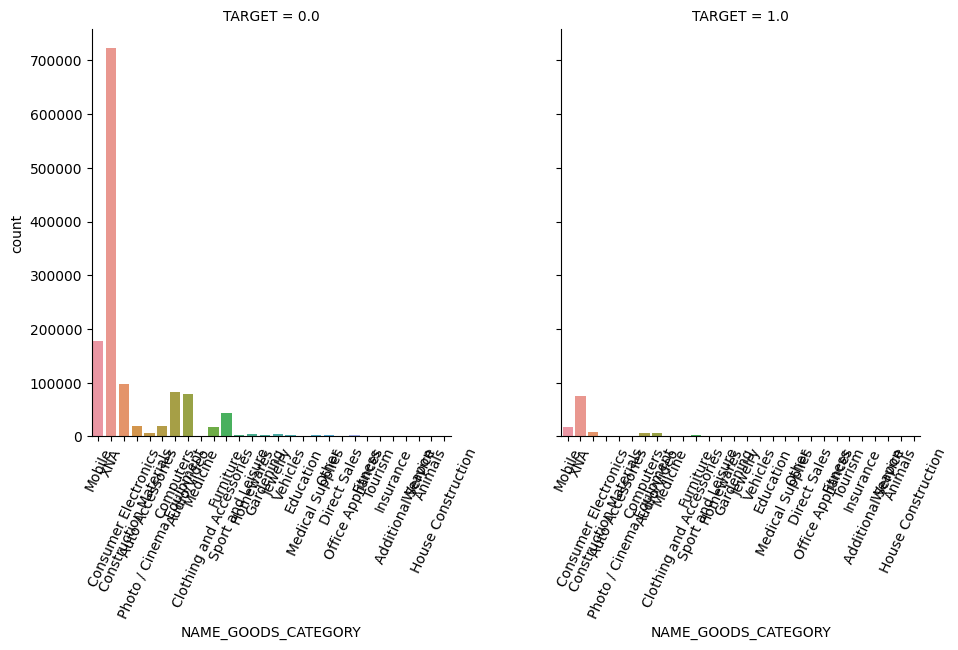

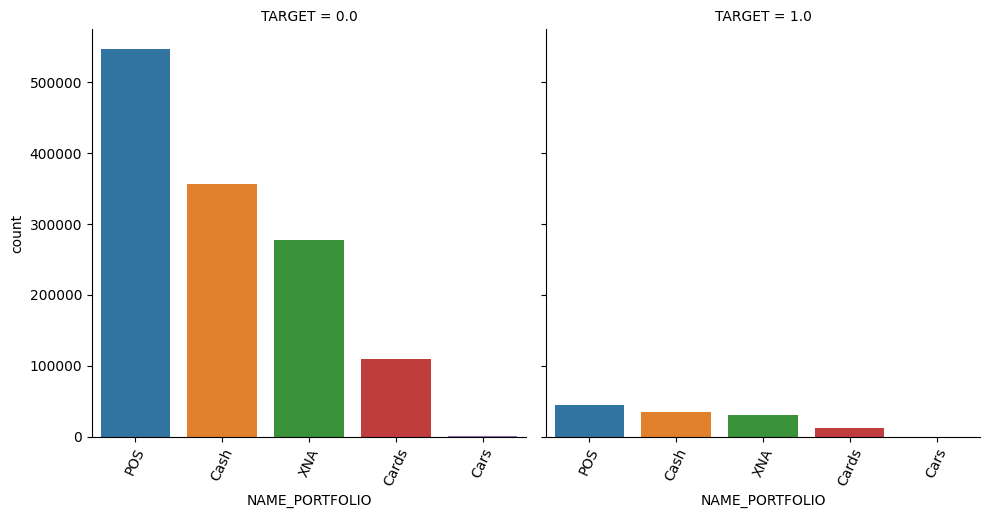

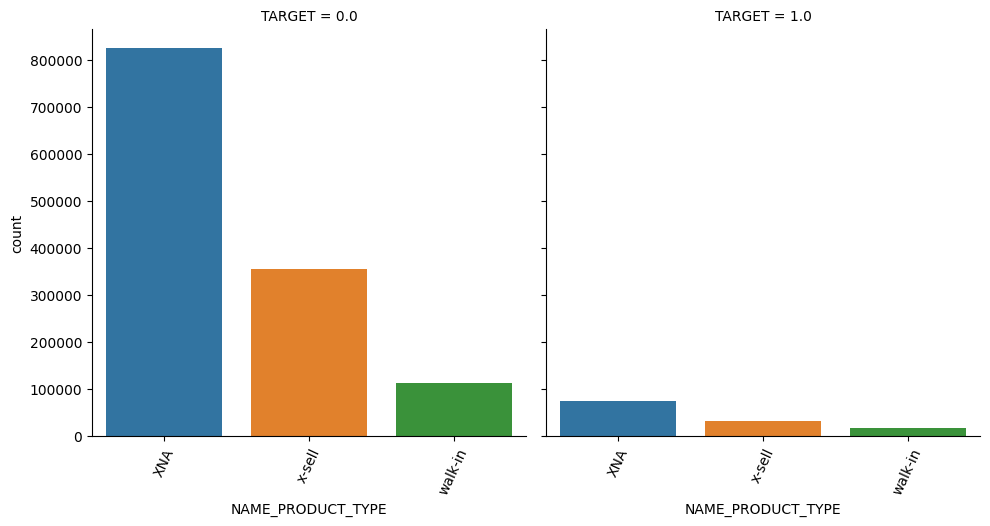

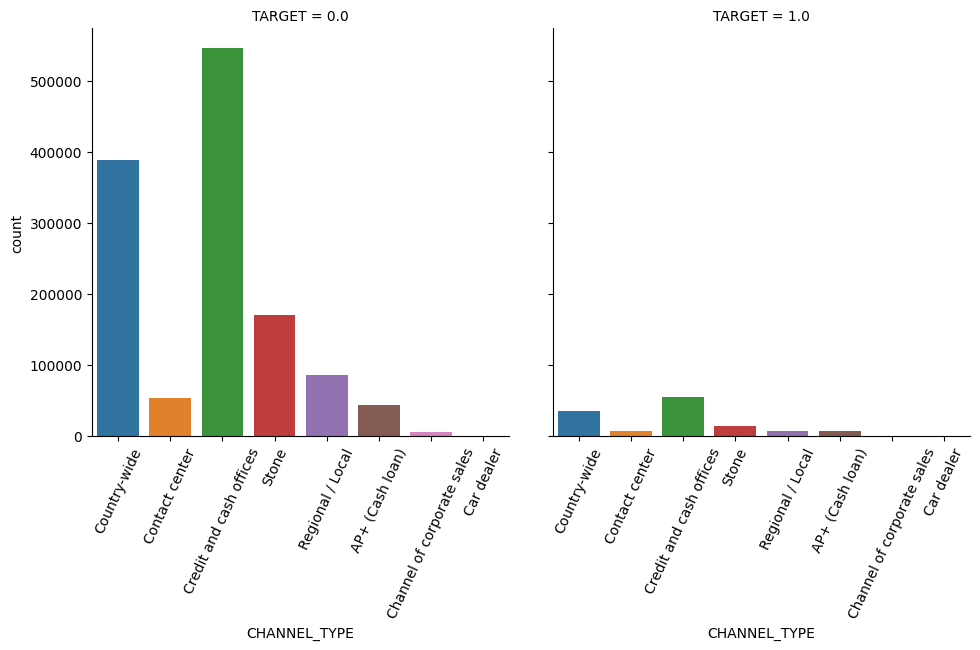

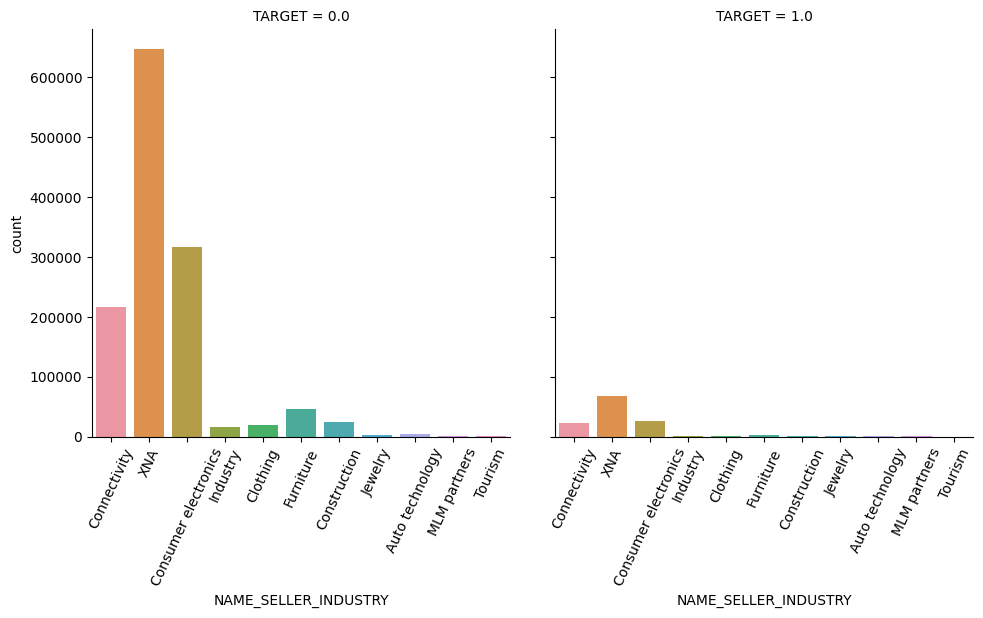

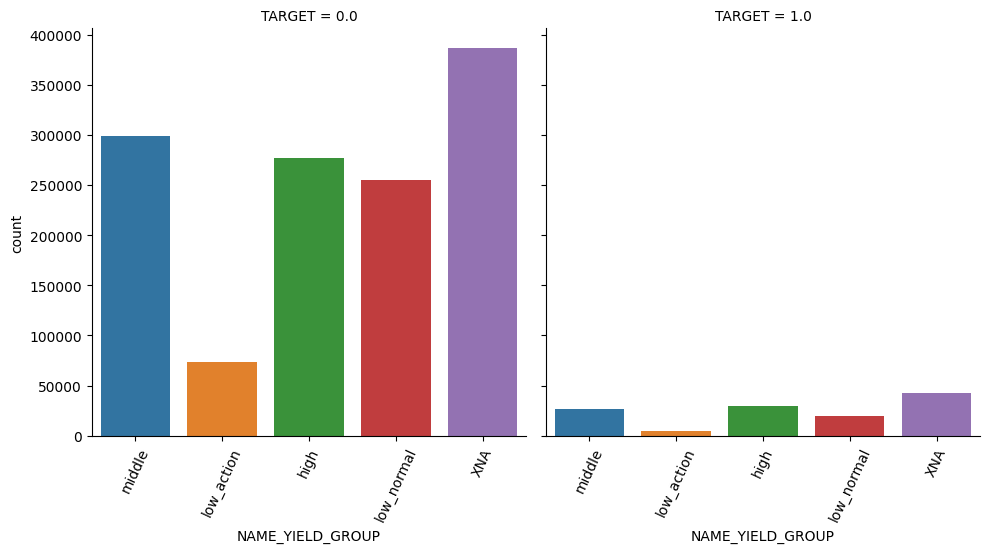

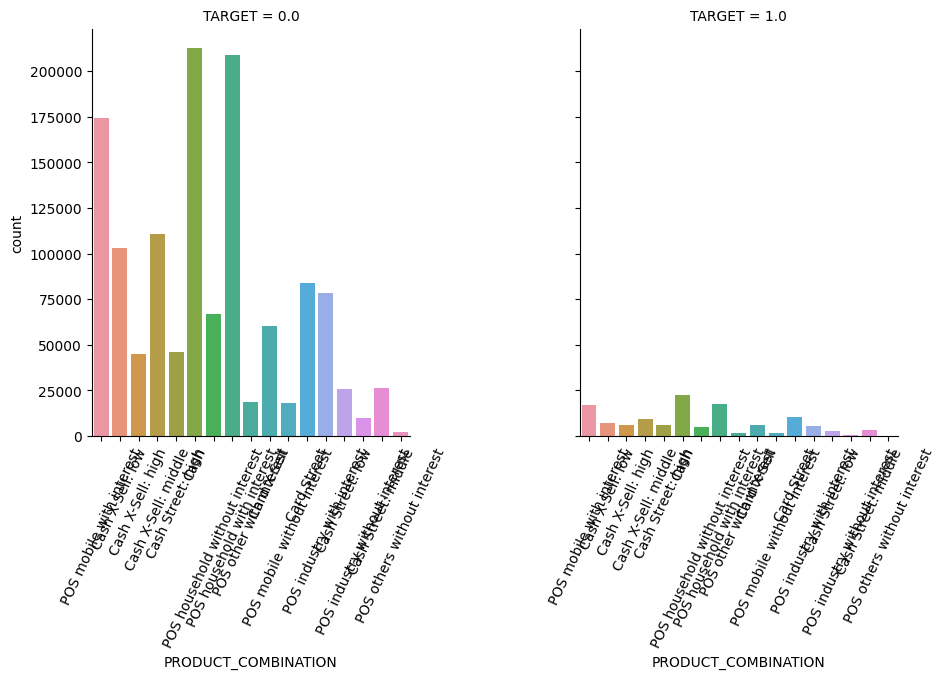

In [27]:
def show_category_by_target(df, columns):
    for column in columns:
        chart = sns.catplot(x=column, col="TARGET", data=df, kind="count")
        chart.set_xticklabels(rotation=65)
        
show_category_by_target(app_prev, object_columns)

* NAME_CONTRACT_TYPE은 TARGET=1일때 CASH_LOAN의 비중이 약간 높음
* NAME_CONTRACT_STATUS(대출허가상태)는 TARGET=1일때 상대적으로 TARGET=0 대비 (당연히) Refused의 비율이 높음. 
* NAME_PAYMENT_TYPE(대출납부방법)는 TARGET=1일때 상대적으로 TARGET=0 대비 XNA의 비율이 약간 높음.

#### prev 데이터 세트 feature engineering 수행. 
- SQL 대비  Pandas groupby 사용 로직 비교
- SQL로 SK_ID_CURR별 건수, 평균 AMT_CREDIT, 최대 AMT_CREDIT, 최소 AMT_CREDIT 구하기

In [28]:
'''
SQL 이라면?
select sk_id_curr, count(*), avg(amt_credit) , max(amt_credit), min(amt_credit) from previous group by sk_id_curr
'''

'\nSQL 이라면?\nselect sk_id_curr, count(*), avg(amt_credit) , max(amt_credit), min(amt_credit) from previous group by sk_id_curr\n'

#### pandas groupby 단일 aggregationi 함수 사용
- groupby SK_ID_CURR
- SK_ID_CURR별 건수, AMT_CREDIT에 대한 평균, 최대 값

In [29]:
prev.groupby('SK_ID_CURR')

In [31]:
# DataFrameGroupby 생성
prev_group = prev.groupby('SK_ID_CURR')

# DataFrameGroupby 객체에 aggregation 함수 수행 결과를 저장한 DataFrame 생성 및 aggregation값 저장
prev_agg = pd.DataFrame()
prev_agg['CNT'] = prev_group['SK_ID_CURR'].count()
prev_agg['AVG_CREDIT'] = prev_group['SK_ID_CURR'].mean()
prev_agg['MAX_CREDIT'] = prev_group['SK_ID_CURR'].max()

prev_agg.head()

,CNT,AVG_CREDIT,MAX_CREDIT
SK_ID_CURR,,,
100001,1,100001.0,100001
100002,1,100002.0,100002
100003,3,100003.0,100003
100004,1,100004.0,100004
100005,2,100005.0,100005


In [32]:
# groupby agg() 함수를 이용하여 여러개의 aggregation 함수 적용
prev_group = prev.groupby('SK_ID_CURR')

prev_agg1 = prev_group['AMT_CREDIT'].agg(['mean', 'max', 'sum'])
prev_agg2 = prev_group['AMT_ANNUITY'].agg(['mean', 'max', 'sum'])
prev_agg = prev_agg1.merge(prev_agg2, on='SK_ID_CURR', how='inner')
prev_agg.head(10)

,mean_x,max_x,sum_x,mean_y,max_y,sum_y
SK_ID_CURR,,,,,,
100001,23787.000000,23787.0,23787.0,3951.000000,3951.000,3951.000
100002,179055.000000,179055.0,179055.0,9251.775000,9251.775,9251.775
100003,484191.000000,1035882.0,1452573.0,56553.990000,98356.995,169661.970
100004,20106.000000,20106.0,20106.0,5357.250000,5357.250,5357.250
100005,20076.750000,40153.5,40153.5,4813.200000,4813.200,4813.200
100006,291695.500000,906615.0,2625259.5,23651.175000,39954.510,141907.050
100007,166638.750000,284400.0,999832.5,12278.805000,22678.785,73672.830
100008,162767.700000,501975.0,813838.5,15839.696250,25309.575,63358.785
100009,70137.642857,98239.5,490963.5,10051.412143,17341.605,70359.885


In [33]:
# agg()에 dictionary를 이용하여 groupby 적용
agg_dict = {
    'SK_ID_CURR':['count'],
    'AMT_CREDIT':['mean', 'max', 'sum'],
    'AMT_ANNUITY':['mean', 'max', 'sum'], 
    'AMT_APPLICATION':['mean', 'max', 'sum'],
    'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
    'AMT_GOODS_PRICE':['mean', 'max', 'sum']
}

prev_group = prev.groupby('SK_ID_CURR')
prev_amt_agg = prev_group.agg(agg_dict)
prev_amt_agg.head()

SK_ID_CURR AMT_CREDIT                       AMT_ANNUITY             \
                count       mean        max        sum        mean        max   
SK_ID_CURR                                                                      
100001              1   23787.00    23787.0    23787.0    3951.000   3951.000   
100002              1  179055.00   179055.0   179055.0    9251.775   9251.775   
100003              3  484191.00  1035882.0  1452573.0   56553.990  98356.995   
100004              1   20106.00    20106.0    20106.0    5357.250   5357.250   
100005              2   20076.75    40153.5    40153.5    4813.200   4813.200   

                       AMT_APPLICATION                      AMT_DOWN_PAYMENT  \
                   sum            mean       max        sum             mean   
SK_ID_CURR                                                                     
100001        3951.000        24835.50   24835.5    24835.5           2520.0   
100002        9251.775       179055.00  179055.0   179055.0              0.0   
100003      169661.970       435436.50  900000.0  1306309.5           3442.5   
100004        5357.250        24282.00   24282.0    24282.0           4860.0   
100005        4813.200        22308.75   44617.5    44617.5           4464.0   

                           AMT_GOODS_PRICE                       
               max     sum            mean       max        sum  
SK_ID_CURR                                                       
100001      2520.0  2520.0         24835.5   24835.5    24835.5  
100002         0.0     0.0        179055.0  179055.0   179055.0  
100003      6885.0  6885.0        435436.5  900000.0  1306309.5  
100004      4860.0  4860.0         24282.0   24282.0    24282.0  
100005      4464.0  4464.0         44617.5   44617.5    44617.5

#### groupby agg로 만들어진 multi index 컬럼 변경
- multi index로 되어 있는 컬럼명 확인
- mulit index 컬럼명을 _로 연결하여 컬럼명 변경

In [34]:
prev_amt_agg.columns

MultiIndex([(      'SK_ID_CURR', 'count'),
            (      'AMT_CREDIT',  'mean'),
            (      'AMT_CREDIT',   'max'),
            (      'AMT_CREDIT',   'sum'),
            (     'AMT_ANNUITY',  'mean'),
            (     'AMT_ANNUITY',   'max'),
            (     'AMT_ANNUITY',   'sum'),
            ( 'AMT_APPLICATION',  'mean'),
            ( 'AMT_APPLICATION',   'max'),
            ( 'AMT_APPLICATION',   'sum'),
            ('AMT_DOWN_PAYMENT',  'mean'),
            ('AMT_DOWN_PAYMENT',   'max'),
            ('AMT_DOWN_PAYMENT',   'sum'),
            ( 'AMT_GOODS_PRICE',  'mean'),
            ( 'AMT_GOODS_PRICE',   'max'),
            ( 'AMT_GOODS_PRICE',   'sum')],
           )

In [37]:
# multi index 컬럼을 '_'로 연결하여 컬럼명 변경
prev_amt_agg.columns = ["PREV_" + "_".join(x).upper() for x in prev_amt_agg.columns.ravel()]

C:\Users\miming\AppData\Local\Temp\ipykernel_6652\4282274646.py:2: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  prev_amt_agg.columns = ["PREV_" + "_".join(x).upper() for x in prev_amt_agg.columns.ravel()]


In [38]:
prev_amt_agg.head()

,PREV_SK_ID_CURR_COUNT,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_SUM,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_SUM,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_SUM,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_SUM,PREV_AMT_GOODS_PRICE_MEAN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,
100001,1,23787.00,23787.0,23787.0,3951.000,3951.000,3951.000,24835.50,24835.5,24835.5,2520.0,2520.0,2520.0,24835.5,24835.5,24835.5
100002,1,179055.00,179055.0,179055.0,9251.775,9251.775,9251.775,179055.00,179055.0,179055.0,0.0,0.0,0.0,179055.0,179055.0,179055.0
100003,3,484191.00,1035882.0,1452573.0,56553.990,98356.995,169661.970,435436.50,900000.0,1306309.5,3442.5,6885.0,6885.0,435436.5,900000.0,1306309.5
100004,1,20106.00,20106.0,20106.0,5357.250,5357.250,5357.250,24282.00,24282.0,24282.0,4860.0,4860.0,4860.0,24282.0,24282.0,24282.0
100005,2,20076.75,40153.5,40153.5,4813.200,4813.200,4813.200,22308.75,44617.5,44617.5,4464.0,4464.0,4464.0,44617.5,44617.5,44617.5
